<a href="https://colab.research.google.com/github/smpark0520/ESAA/blob/main/%ED%95%B8%EC%A6%88%EC%98%A8_7%EC%9E%A5_%EC%95%99%EC%83%81%EB%B8%94_%ED%95%99%EC%8A%B5%EA%B3%BC_%EB%9E%9C%EB%8D%A4_%ED%8F%AC%EB%A0%88%EC%8A%A4%ED%8A%B8_p_245~257(7_1_~_7_4).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 7. 앙상블 학습과 랜덤 포레스트


- **앙상블 학습(Ensemble Learning)**:  
  여러 개의 예측 모델(분류 또는 회귀 모델)로부터 예측을 모아 하나의 최적 예측을 생성하는 방법
  → 개별 모델보다 더 좋은 성능을 낼 수 있음
  → 이를 구현하는 알고리즘이 **앙상블 방법(Ensemble Method)**

- **랜덤 포레스트(Random Forest)**:  
  - 결정 트리(Decision Tree)의 앙상블 모델
  - 훈련 데이터의 무작위 서브셋을 사용해 여러 개의 결정 트리를 학습
  - 예측 시 모든 트리의 결과를 모아 최빈값(분류) 또는 평균(회귀)으로 결정
  - **단순하지만 강력한 머신러닝 알고리즘 중 하나!**


# 7.1 투표 기반 분류기

**직접 투표(Hard Voting) 분류기**

- 여러 개의 분류기(로지스틱 회귀, SVM, 랜덤 포레스트, K-NN 등)를 훈련
- 각 분류기의 예측 결과를 모아 **가장 많이 선택된 클래스를 최종 예측**으로 결정(다수결 투표)

📌 **다수결 투표 분류기는 개별 분류기 중 가장 뛰어난 것보다도 높은 정확도를 가질 수 있음!**

- 개별 분류기가 **약한 학습기(Weak Learner)**(즉, 랜덤보다 조금 더 나은 성능)라도,  
    충분히 많고 다양하면 **강한 학습기(Strong Learner)**가 될 수 있음.  

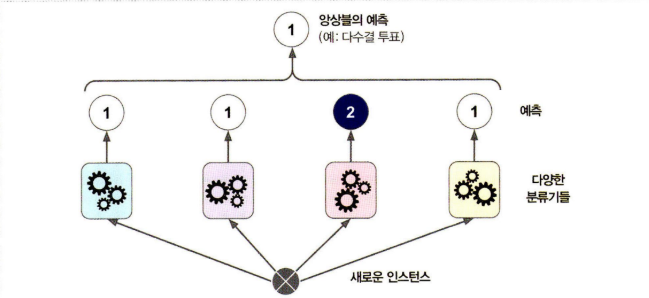

 **앙상블의 성능 향상 원리**  : **큰 수의 법칙(Law of Large Numbers)**  
  - 예를 들어, 앞면이 나올 확률이 51%인 동전을 1,000번 던지면  
    → 앞면이 다수일 확률 ≈ 75%  
    → 10,000번 던지면 97% 이상으로 증가  
  - 실험 횟수가 많아질수록 확률이 수렴하여 예측이 더 안정적으로 됨.  

In [1]:
import warnings
warnings.filterwarnings('ignore')

# import package
import numpy as np
import os

#5장에서 소개한 moons dataset 불러오기
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

X,y = make_moons(n_samples=100, noise=0.15)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(
    estimators = [('lr',log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard'
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

In [3]:
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.8
RandomForestClassifier 0.9
SVC 0.95
VotingClassifier 0.9


- **간접 투표 (Soft Voting)**  
  - 클래스의 확률을 평균 내어 가장 높은 확률을 가진 클래스를 예측
  - `voting='soft'`로 설정하면, 성능이 더 향상됨 (직접 투표보다 높은 정확도)
  - SVC : 기본적으로 `predict_proba()` 메서드를 제공하지 않으므로 `probability=True`로 설정

# 7.2 배깅과 페이스팅



| 방법       | 샘플링 방식          | 중복 허용 여부        | 설명                            |
|------------|----------------------|-----------------------|---------------------------------|
| **배깅**   | 무작위 샘플링         | **허용**               | 같은 훈련 샘플을 여러 번 사용할 수 있음. |
| **페이스팅**| 무작위 샘플링         | **허용하지 않음**      | 각 훈련 샘플을 한 번만 사용.    |


### **앙상블의 예측과 편향-분산**

- **예측 생성**:  
  앙상블은 모든 예측기의 예측을 모아서 새로운 샘플에 대한 예측을 만듦.  
  - **분류**: 통계적 최빈값(가장 많은 예측 결과, 직접 투표 방식)
  - **회귀**: 예측값의 평균

- **편향과 분산**:  
  - 개별 예측기는 훈련 세트로부터 **편향이 크게** 발생할 수 있음.  
  - 그러나 앙상블에서 **수집 함수를 통과**하면 편향과 분산이 모두 감소.  
  - **결과**: 앙상블은 원본 데이터로 훈련된 단일 예측기보다 **편향은 비슷**하고 **분산은 줄어듦**.

## 7.2.1 사이킷런과 배깅과 페이스팅

### 배깅 (Bagging)
- **Bagging Classifier** (회귀의 경우: `BaggingRegressor`)  
  - 각 분류기는 중복을 허용한 100개의 샘플로 훈련
  - `bootstrap=True`가 기본값
  - 예시: 결정 트리 분류기 500개 앙상블 훈련
  
### 페이스팅 (Pasting)
- **Pasting**  
  - 각 분류기는 중복을 허용하지 않은 100개의 샘플로 훈련
  - `bootstrap=False`로 설정

### 병렬 처리
  - `n_jobs` : CPU 코어 수를 지정
  - `n_jobs=-1` : 모든 가용 코어 사용

In [4]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=50, bootstrap=True, n_jobs=-1)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

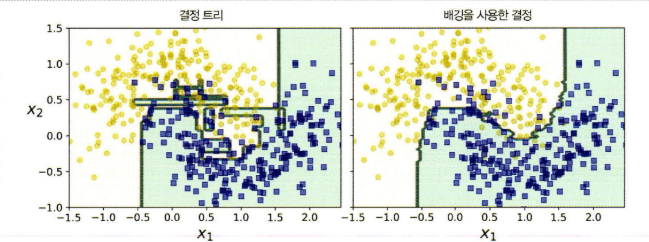

- 단일 결정 트리와 50개의 트리를 사용한 배깅 앙상블의 결정 경계를 비교

- **결과**:
  - 앙상블의 예측이 단일 결정 트리보다 일반화가 잘 됨
  - 앙상블은 비슷한 편향에서 더 작은 분산을 만듦
  - 결정 경계: 앙상블은 덜 불규칙하고, 훈련 세트의 오차 수는 거의 비슷


- **부트스트래핑**:  
  - 편향 : 배깅 > 페이스팅

- 다양성 추가 ➡ 예측기 상관관계 ↓ ➡ 분산 ↓  

- **결론**:  
  - 배깅: **일반적으로 더 나은 모델**  
  - **교차 검증**으로 배깅/페이스팅 평가 후 선택.


## 7.2.2 oob 평가

- **배깅**: 샘플 중 일부는 여러 번 샘플링, 일부는 선택되지 않음
- **BaggingClassifier**:
  - 평균적으로 훈련 샘플의 **63%만 샘플링**되고, 나머지 **37%**는 선택되지 않음.
  - OOB (Out-of-Bag) 샘플 :선택되지 않은 37%의 샘플로, 이를 검증 세트처럼 사용.
- **OOB 평가**:
  - 각 예측기의 OOB 샘플을 이용해 평가
  - `oob_score=True` : 훈련 후 자동으로 OOB 평가가 수행되고, 평가 점수는 `oob_score_` 변수에 저장

In [5]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True)

bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.925

In [6]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.8

In [7]:
bag_clf.oob_decision_function_

array([[0.00518135, 0.99481865],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.06358382, 0.93641618],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.59036145, 0.40963855],
       [0.29292929, 0.70707071],
       [0.64673913, 0.35326087],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.06451613, 0.93548387],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [0.53723404, 0.46276596],
       [0.        , 1.        ],
       [0.015     , 0.985     ],
       [1.        , 0.        ],
       [0.21428571, 0.78571429],
       [1.        , 0.        ],
       [0.99468085, 0.00531915],
       [0.        , 1.        ],
       [0.91326531, 0.08673469],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.76023392, 0.23976608],
       [0.

# 7.3 랜덤 패치와 랜덤 서브스페이스

BaggingClassifier의 특성 샘플링

- **특성 샘플링**:
  - **max_features**와 **bootstrap_features** 매개변수로 조절.
  - 각 예측기는 **무작위로 선택된 입력 특성**의 일부로 훈련됨.

- **랜덤 패치 방식 (Random Patches)**:
  - **샘플링**: 훈련 샘플과 특성 모두 샘플링.
  - **고차원 데이터**(예: 이미지)에 유용.

- **랜덤 서브스페이스 방식 (Random Subspaces)**:
  - **샘플링**: 훈련 샘플은 모두 사용하고, 특성만 샘플링.
  - **편향 증가**, **분산 감소**.

# 7.4 랜덤 포레스트

- 배깅(Bagging) 방법을 사용한 결정 트리 앙상블 모델
- `RandomForestClassifier`: 분류 문제
- `RandomForestRegressor`: 회귀 문제
- 다수의 결정 트리를 사용하여 예측 성능 향상
- 병렬 학습: 여러 CPU 코어에서 훈련 가능
- 특성 샘플링과 부트스트래핑을 통해 예측의 다양성 증가

-  (최대 16개의 리프 노드를 갖는) 500개 트리로 이뤄진 랜덤 포레스트 분류기를 여러 CPU 코어에서 훈련시키는 코드

In [8]:
from sklearn.ensemble import RandomForestClassifier
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

### 🎯 RandomForestClassifier 특징  

- DecisionTreeClassifier와 BaggingClassifier의 매개변수를 대부분 포함  
- 트리 노드 분할 시 전체 특성이 아닌, 무작위 선택된 일부 특성 중 최적의 특성을 선택 → 트리 다양성 증가  
- 편향(Bias)은 증가하지만, 분산(Variance)은 감소 → 일반화 성능 향상  


- `BaggingClassifier`를 사용하여 RandomForestClassifier와 유사한 모델 구현 가능

In [9]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="auto", max_leaf_nodes=16),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1)

## 7.4.1 엑스트라 트리

### 🌲 익스트림 랜덤 트리 (Extra Trees)  

- **랜덤 포레스트보다 더 무작위한 트리 생성**  
  - 각 노드에서 **특성의 서브셋**을 무작위 선택  
  - 최적의 임곗값을 찾지 않고 **임곗값도 무작위 선택** 후 최적의 분할 결정  

- **장점**  
  - 랜덤 포레스트보다 **더 낮은 분산(Variance)**  
  - **더 빠른 학습 속도** (임곗값 최적화 과정 생략)  

- **사용법**  
  - `ExtraTreesClassifier` → 분류  
  - `ExtraTreesRegressor` → 회귀  
  - `RandomForestClassifier`와 동일한 API 사용  

🚀 **편향(Bias)은 증가하지만, 분산을 낮춰 더 안정적인 모델을 만듦!**  

## 7.4.2 특성 중요도

### 🔥 랜덤 포레스트의 특성 중요도 측정  

- **특성 중요도 계산 방법**  
  - 각 특성이 **불순도를 얼마나 감소**시키는지 측정  
  - 랜덤 포레스트 내 모든 트리에서 평균적으로 기여한 정도를 계산  
  - **가중치 평균** 사용 (각 노드의 가중치는 연관된 샘플 수)  

- **사이킷런에서 특성 중요도 확인**  
  - `feature_importances_` 속성에 저장  
  - 모든 특성 중요도의 합이 **1로 정규화**됨    

📊 **특성 중요도를 분석하면 모델이 어떤 요인을 중요하게 생각하는지 이해할 수 있음!**  

- **예시 (Iris 데이터셋)**  
  - 가장 중요한 특성: **꽃잎 길이(44%) & 꽃잎 너비(42%)**  
  - 덜 중요한 특성: **꽃받침 길이(11%) & 꽃받침 너비(2%)**

In [10]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.09257140576315062
sepal width (cm) 0.023208906162834494
petal length (cm) 0.4189535333028065
petal width (cm) 0.4652661547712083


- **MNIST 데이터셋 + 랜덤 포레스트 분류기** 적용   
- 밝을수록 **모델이 중요하게 생각하는 픽셀**

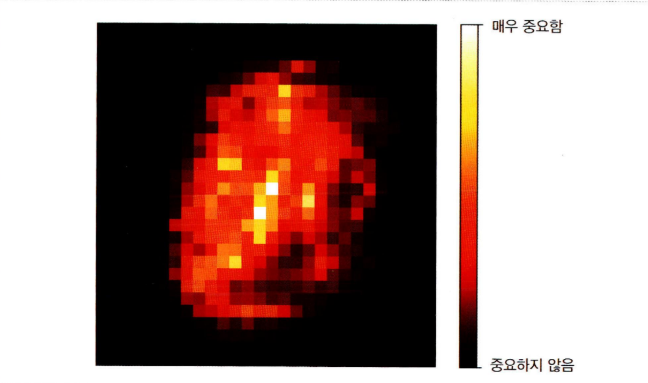